# Evaluation of test year GCM-driven run

In [61]:
import valenspy as vp
from valenspy._utilities import load_yml
from valenspy.preprocessing_tasks.select import select_point
from valenspy.diagnostic_functions import mean_bias, mean_absolute_error, root_mean_square_error, spearman_correlation, perkins_skill_score, time_series_spatial_mean
from valenspy.diagnostic_visualizations import plot_time_series, plot_map
from pathlib import Path

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd


# define machine name - used for paths of (observational) datasets
machine = 'hortense'

manager = vp.InputManager(machine=machine)


## TO DO (Fien)
1. Add -10 at boundaries
2. Include checks for the extremes
3. Add option to select region to functions

## 0. Pre-defining 

In [62]:
# Define reference datasets
reference = 'ERA5'
test_set = 'EC-Earth'
domain = 'BE28'
model = "CCLM"

variable = 'pr'
variable = "T_2M"
daily_statistic = "mean"
statistics = ["mean", "min", "max"]

## 1. Functions
--> fully tested, are working 

In [63]:
def load_data_exp(variable, model, experiment):

    if variable in ['tas','clt', 'clh', 'clm', 'cll']:
        daily_statistic = "mean"
    #    ds_exp = ds_obs.resample(time='1D').mean()

    elif variable == 'pr': 
 
        daily_statistic = "sum"
   #     ds_obs = ds_obs.resample(time='1D').sum()

    elif variable == "tasmax": 
        daily_statistic = "max"
       # ds_obs = ds_obs.resample(time='1D').max()

    ds_mod = manager.load_data(model, [variable], freq="hourly", path_identifiers=[experiment, daily_statistic])


    ds_mod['time'] = ds_mod['time'].dt.floor('D')


    da_exp = ds_mod[variable].compute()

    return da_exp

In [64]:
def get_spaghetti_GLUE(da_eval: xr.DataArray, da_exp: xr.DataArray, variable: str): 

    """
    Plots the yearly cycle for each year in the evaluation dataset (`da_eval`)
    and the experimental dataset (`da_exp`), starting on January 1st for all.

    Parameters:
        da_eval (xarray.Dataset): Evaluation dataset with multiple years.
        da_exp (xarray.Dataset): Experimental dataset with a single year.
        variable (str): The name of the variable to plot.

    Returns:
        None: Displays the plot.
    """
    plt.figure(figsize = (20,6))
    
    # Exctract unique years
    years_eval = np.unique(pd.to_datetime(da_eval.time).year)
    years_exp = np.unique(pd.to_datetime(da_exp.time).year)

    # # Loop over all years:
    for yr in years_eval:
        ds_year = da_eval.sel(time=da_eval.time.dt.year.isin([yr]))
        print("In year " + str(yr) + ' we have ' + str(len(ds_year["time"])) + " datapoints.")
        if isinstance(ds_year, xr.Dataset):
            da_year = ds_year[variable]
        else:
            da_year = ds_year
        df_year = da_year
        da_year["doy"] = da_year['time'].dt.dayofyear

        plt.plot(da_year['doy'], da_year, color = "grey")

    for yr in years_exp:
        ds_year = da_exp.sel(time=da_exp.time.dt.year.isin([yr]))
        print("In year " + str(yr) + ' we have ' + str(len(ds_year["time"])) + " datapoints.")
        if isinstance(ds_year, xr.Dataset):
            da_year = ds_year[variable]
        else:
            da_year = ds_year
        df_year = da_year
        da_year["doy"] = da_year['time'].dt.dayofyear

        plt.plot(da_year['doy'], da_year, label="Experimental Dataset" , color = "red")

    # Customize Plot
    plt.title(f"Yearly Cycle of " + da_eval.long_name)
    plt.xlabel("Day of Year")
    plt.ylabel(variable + " [" + da_eval.units + "]")
    #plt.ylim([270,300])
    plt.legend(loc='upper right', fontsize='small', ncol=2)  # Adjust legend
    plt.grid()
    plt.show()


In [65]:
def get_temporal_stats(dataset, variable, frequency="yearly", statistics = ['mean'], percentiles=None):
    """
    Compute statistics for a specified variable in an xarray Dataset, either yearly or daily within each year.
    
    Parameters:
        dataset (xr.Dataset): The input dataset containing the variable.
        variable (str): The name of the variable to compute statistics on.
        frequency (str): "yearly" for statistics per year, "daily" for each day within the year (default: "yearly").
        statistics: list with statistics to calculate (defalut: mean)
            options: mean, median, min, max, std
        percentiles (list): List of percentiles to compute (default: None).
        
    Returns:
        xr.Dataset: A Dataset containing the requested statistics for the selected variable.
    """
    if variable not in dataset:
        raise ValueError(f"Variable '{variable}' not found in the dataset.")
    
    # Group data by the specified frequency
    if frequency == "yearly":
        grouped_data = dataset[variable].groupby("time.year")
    elif frequency == "daily":
        grouped_data = dataset[variable].groupby("time.dayofyear")
    else:
        raise ValueError("Frequency must be either 'yearly' or 'daily'.")
    
    # Create a dictionary to store computed statistics
    stats = {}
    if 'mean' in statistics:
        stats['mean'] = grouped_data.mean(dim="time")
        print("Calculated mean")
    if 'median' in statistics:
        stats['median'] = grouped_data.reduce(xr.DataArray.quantile, dim="time", q=0.5)
        print("Calculated median")
    if 'min' in statistics:
        stats['min'] = grouped_data.min(dim="time")
        print("Calculated min")
    if 'max' in statistics:
        stats['max'] = grouped_data.max(dim="time")
        print("Calculated max")
    if 'std' in statistics:
        stats['std'] = grouped_data.std(dim="time")
        print("Calculated std")
    if percentiles:
        for p in percentiles:
            stats[f"p{int(p)}"] = grouped_data.reduce(
                xr.DataArray.quantile, dim="time", q=p/100
            )
            print("Calculated " + str(p) + "th percentile")
    
    # Create a new Dataset with the statistics as variables
    stats_dataset = xr.Dataset(stats)
    
    return stats_dataset

In [66]:
def rank_years(da: xr.DataArray, dim: str = "year") -> dict:
    """
    Ranks yearly values in an xarray DataArray and returns the years with the highest and lowest values.
    
    Parameters:
        da (xr.DataArray): Input DataArray with a time dimension representing years.
        dim (str): The dimension along which to rank. Default is "year".
    
    Returns:
        dict: A dictionary with the highest and lowest year and their corresponding values.
              Example: {"highest": {"year": 2000, "value": 34.5}, 
                        "lowest": {"year": 1990, "value": -23.1}}
    """
    # Ensure the DataArray has the specified dimension
    if dim not in da.dims:
        raise ValueError(f"Dimension '{dim}' not found in the DataArray.")
    
    # Identify the highest and lowest values
    highest_idx = da.argmax(dim=dim).item()  # Index of the max value
    lowest_idx = da.argmin(dim=dim).item()   # Index of the min value
    
    # Retrieve the corresponding years (assuming `dim` coordinates represent years)
    highest_year = da[dim].isel({dim: highest_idx}).item()
    lowest_year = da[dim].isel({dim: lowest_idx}).item()
    
    # Retrieve the corresponding values
    highest_value = da.isel({dim: highest_idx}).item()
    lowest_value = da.isel({dim: lowest_idx}).item()
    
    return {
        "highest": {"year": highest_year, "value": highest_value},
        "lowest": {"year": lowest_year, "value": lowest_value},
    }

# Example usage
# Assuming `da` has yearly data with dimension "year"
# result = rank_years(da, dim="year")
# print(result)


In [67]:
def get_spatial_stats(dataset, variable, statistics=['mean'], percentiles=None, region='belgium'):
    """
    Compute spatial statistics for a specified variable in an xarray Dataset.
    
    Parameters:
        dataset (xr.Dataset): The input dataset containing the variable of interest.
        variable (str): The name of the variable for which to compute statistics.
        statistics (list): List of statistics to calculate (default: ['mean']).
            Options: 'mean', 'median', 'min', 'max', 'std'.
        percentiles (list, optional): List of percentiles to compute, expressed as integers (e.g., [25, 75]). Default is None.
        region (str, optional): Placeholder for region-based selection functionality. Default is 'belgium'.
        
    Returns:
        xr.Dataset: A Dataset containing the computed statistics for the selected variable.
    
    Raises:
        ValueError: If the specified variable is not found in the dataset.
    
    Notes:
        - The function calculates statistics over the time dimension.
        - If additional region-based selection is needed, this can be implemented using external functionality (e.g., `select_region`).
    """
    if variable not in dataset:
        raise ValueError(f"Variable '{variable}' not found in the dataset.")
    
    # Extract the variable as a DataArray
    data_array = dataset[variable]
    
    # Create a dictionary to store computed statistics
    stats = {}
    if 'mean' in statistics:
        stats['mean'] = data_array.mean(dim="time")
    if 'median' in statistics:
        stats['median'] = data_array.quantile(0.5, dim="time")
    if 'min' in statistics:
        stats['min'] = data_array.min(dim="time")
    if 'max' in statistics:
        stats['max'] = data_array.max(dim="time")
    if 'std' in statistics:
        stats['std'] = data_array.std(dim="time")
    if percentiles:
        for p in percentiles:
            stats[f"p{int(p)}"] = data_array.quantile(p/100, dim="time")
    
    # Create a new Dataset with the statistics as variables
    stats_dataset = xr.Dataset(stats)

    # still to be implemented
    # if '/' not in region:
    #     stats_dataset = select_region(stats_dataset, region)
    
    return stats_dataset


In [68]:
def crop_outer_box(da: xr.DataArray, n_points: int = 10) -> xr.DataArray:
    """
    Crops the outer box of an xarray DataArray by removing a specified number of points
    from each edge along all dimensions.
    
    Parameters:
        da (xr.DataArray): The input DataArray.
        n_points (int): The number of points to remove from each edge. Default is 10.
    
    Returns:
        xr.DataArray: The cropped DataArray.
    """
    # Validate the DataArray has sufficient points along each dimension
    for dim in ['rlon','rlat']:
        if da.sizes[dim] <= 2 * n_points:
            raise ValueError(
                f"Dimension '{dim}' is too small to crop {n_points} points from each side."
            )
    
    # Slice each dimension
    sliced_da = da.isel({dim: slice(n_points, -n_points) for dim in da.dims})
    
    return sliced_da

# Example usage
# Assuming `da` is your xarray.DataArray
# cropped_da = crop_outer_box(da, n_points=10)


In [69]:
def plot_temporal_stats(eval_dataset, test_dataset, variable, statistics, frequency = "yearly"):
    """
    Plots temporal statistics from the evaluation dataset and compares them with the test dataset.
    
    Parameters:
        eval_dataset (xr.Dataset): The dataset containing evaluation statistics (mean, min, max, std, etc.).
        test_dataset (xr.Dataset): The dataset containing the test data.
        variable (str): The name of the variable in the test dataset to plot.
        statistics (list): List of statistics to plot from the evaluation dataset (e.g., ['mean', 'min', 'max', 'std']).
        
    Returns:
        matplotlib.figure.Figure: The generated plot figure.
    """
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(20, 6))
    
    # Color map for statistics
    color_map = {
        'mean': 'blue',
        'min': 'green',
        'max': 'red',
        'std': 'grey'
    }

    # Define temporal frequency
    if frequency == "daily":
        variable_freq = "dayofyear"
        plot_label = "Day Of Year"
        test_dataset[variable_freq] = test_dataset['time'].dt.dayofyear
    elif frequency == "yearly":
        variable_freq = "year"
        plot_label = "year"
        test_dataset[variable_freq] = test_dataset['time'].dt.year

    if variable_freq not in eval_dataset.dims:
        return print(f'Error: Requested {frequency} frequency not available in '
                f'{eval_dataset}.')
    
    # Plot the test dataset
    if frequency == "yearly":
        if statistics[0] not in test_dataset.dims:
            test_dataset_stats = get_temporal_stats(dataset = test_dataset, variable = variable, frequency="yearly", statistics = statistics)
        for stat in statistics:
            ax.scatter(
                test_dataset_stats[variable_freq], 
                test_dataset_stats[stat], 
                label=f'Test Data {stat}', 
                color='black', 
                linestyle='--'
                )    

    else:
        ax.plot(
            test_dataset[variable_freq], 
            test_dataset[variable], 
            label='Test Data', 
            color='black', 
            linestyle='--'
            )
        
    print(f"Succesfully plotted the testdataset")
    
    # Plot each requested statistic from the evaluation dataset
    for stat in statistics:
        if stat in eval_dataset:
            if frequency == 'daily':
                if stat == 'std':
                    # Plot std as a shaded area around the mean
                    if 'mean' in eval_dataset:
                        mean_values = eval_dataset['mean']
                        std_values = eval_dataset['std']
                        ax.fill_between(
                            eval_dataset[variable_freq], 
                            mean_values - std_values, 
                            mean_values + std_values, 
                            color=color_map.get(stat, 'grey'), 
                            alpha=0.3, 
                            label='Standard Deviation'
                        )
                        print(f"Succesfully plotted {stat.capitalize()} ")
                else:
                    # Plot other statistics as lines
                    ax.plot(
                        eval_dataset[variable_freq], 
                        eval_dataset[stat], 
                        label=f'Evaluation {stat.capitalize()}', 
                        color=color_map.get(stat, 'black')
                    )
                    print(f"Succesfully plotted {stat.capitalize()} ")
            if frequency == "yearly":
                if stat == 'std':
                    # Plot std as a shaded area around the mean
                    if 'mean' in eval_dataset:
                        mean_values = eval_dataset['mean']
                        std_values = eval_dataset['std']
                        ax.fill_between(
                            eval_dataset[variable_freq], 
                            mean_values - std_values, 
                            mean_values + std_values, 
                            color=color_map.get(stat, 'grey'), 
                            alpha=0.3, 
                            label='Standard Deviation'
                        )
                        print(f"Succesfully plotted {stat.capitalize()} ")
                else:
                    # Wrap data in a list for boxplot
                    # data = [eval_dataset[stat].values.flatten()]  # List of statistics for boxplot
                    # ax.boxplot(data, 
                    #            positions=[1],  # Positioning each boxplot
                    #            labels=[stat.capitalize()],  # Single label for the statistic
                    #            patch_artist=True
                    # )
                    ax.scatter(
                        test_dataset_stats[variable_freq], 
                        test_dataset_stats[stat], 
                        label=f'Test Data {stat}', 
                        color=color_map.get(stat, 'grey'), 
                        linestyle='--'
                        )    
                    print(f"Succesfully plotted {stat.capitalize()} ")

    
    # Add labels, legend, and title
    ax.set_title(f"{frequency.capitalize()} Statistics for {variable.capitalize()} (Evaluation vs Test)", fontsize=16)
    ax.set_xlabel(plot_label, fontsize=14)
    ax.set_ylabel(f"{variable.capitalize()} Value", fontsize=14)
    ax.set_ylim([270,300])  # Adjust based on your variable's range
    ax.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return fig, ax


In [70]:
def plot_spatial_stats(stat_eval_spatial, stat_exp_spatial, variable, statistics):
    """
    Plot comparisons of statistics between two xarray Datasets (stat_eval_spatial and stat_exp_spatial).
    
    Parameters:
        stat_eval_spatial (xr.Dataset): Dataset containing evaluation statistics.
        stat_exp_spatial (xr.Dataset): Dataset containing expected statistics.
        variable (str): The name of the variable to compare.
        statistics (list): List of statistics to compare and plot (e.g., ['mean', 'min', 'max']).
    
    Raises:
        ValueError: If a statistic is not present in either dataset.
    """
    # Check if all statistics are present in both datasets
    missing_stats = [stat for stat in statistics if stat not in stat_eval_spatial or stat not in stat_exp_spatial]
    if missing_stats:
        raise ValueError(f"Statistic(s) {missing_stats} are missing in one of the datasets.")
    
    # Compute the difference dataset
    diff_dataset = stat_exp_spatial - stat_eval_spatial
    print("1 done")
    # Compute global colorbar limits for difference
    #diff_values = np.concatenate([diff_dataset[stat].values.flatten() for stat in statistics])
    #diff_vmin, diff_vmax = np.nanmin(diff_values), np.nanmax(diff_values)

    # Create plots
    for stat in statistics:
        eval_data = stat_eval_spatial[stat]
        exp_data = stat_exp_spatial[stat]
        diff_data = diff_dataset[stat]
        print("2 done")

        # Determine colorbar limits for eval/exp
        eval_exp_vmin = min(eval_data.min().values, exp_data.min().values)
        eval_exp_vmax = max(eval_data.max().values, exp_data.max().values)
        print('ready to plot')
        plot_maps_mod_ref_diff(da_mod = exp_data, da_ref = eval_data,da_diff = diff_data,
                               region=None)



In [71]:
def min_max_scaling(eval_dataset, exp_dataset, variable):
    """
    Visualize spatial grid data with absolute minima, maxima, and scaled values.

    Parameters:
        eval_dataset (xarray.Dataset): A Dataset containing a 3D variable (time x lat x lon)
            with yearly means for each grid cell.
        exp_dataset (xarray.Dataset): A Dataset containing a 2D variable (lat x lon) with averages over all days.

    Returns:
        da with minima, da with maxima and da with scaling
    """

    # Compute absolute minima and maxima for each grid cell in eval_dataset
    print("Started with determining absolute minima and maxima")
    da_abs_minima = eval_dataset.min(dim = "year")[variable]
    da_abs_maxima = eval_dataset.max(dim = "year")[variable]

    # Min-max scaling for exp_dataset
    print("Started with scaling")
    scaled_exp = (exp_dataset[variable] - da_abs_minima) / (da_abs_maxima - da_abs_minima)
    print("experiment is scaled")

    return da_abs_minima, da_abs_maxima, scaled_exp
    # # Determine the global color scale for minima and maxima


In [72]:
def visualize_min_max_scaling(da_abs_minima, da_abs_maxima, scaled_exp, region=None, variable="tas"):
    """
    Visualizes the absolute minima, absolute maxima, and scaled experimental dataset on 3 maps.

    Parameters:
    -----------
    da_abs_minima : xr.DataArray
        The DataArray containing the absolute minima.
    da_abs_maxima : xr.DataArray
        The DataArray containing the absolute maxima.
    scaled_exp : xr.DataArray
        The DataArray containing the scaled experimental data.
    """
    # Create the figure and axes
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Calculate global min and max
    vmin = da_abs_minima.min().values
    vmax = da_abs_maxima.max().values
    
    # Plot 1: Absolute minima
    print("Plotting minima")
    p1 = da_abs_minima.plot(ax=axes[0], add_colorbar=False, cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[0].set_title("Absolute Minima (eval_dataset)")
    cbar1 = fig.colorbar(p1, ax=axes[0], orientation='vertical')
    cbar1.set_label(f"{da_abs_minima.attrs.get('long_name', 'Minima')} ({da_abs_minima.attrs.get('units', '')})")

    # Plot 2: Scaled experimental data
    print("Plotting scaled experiment data")
    p2 = scaled_exp.plot(ax=axes[1], add_colorbar=False, cmap='viridis')
    axes[1].set_title("[test - min]/[max - min]")
    cbar2 = fig.colorbar(p2, ax=axes[1], orientation='vertical')
    #cbar2.set_label(f"{scaled_exp.attrs.get('long_name', 'Scaled Exp')} ({scaled_exp.attrs.get('units', '')})")

    # Plot 3: Absolute maxima
    print("Plotting maxima")
    p3 = da_abs_maxima.plot(ax=axes[2], add_colorbar=False, cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[2].set_title("Absolute Maxima (eval_dataset)")
    cbar3 = fig.colorbar(p3, ax=axes[2], orientation='vertical')
    cbar3.set_label(f"{da_abs_maxima.attrs.get('long_name', 'Maxima')} ({da_abs_maxima.attrs.get('units', '')})")

    # Adjust layout
    plt.tight_layout()
    plt.show()


In [73]:
def visualize_eval_exp_diff(da_eval, da_exp, da_diff, variable = None, statistic = "mean",region=None):
    """
    Visualizes the absolute minima, absolute maxima, and scaled experimental dataset on 3 maps.

    Parameters:
    -----------
    da_abs_minima : xr.DataArray
        The DataArray containing the absolute minima.
    da_abs_maxima : xr.DataArray
        The DataArray containing the absolute maxima.
    scaled_exp : xr.DataArray
        The DataArray containing the scaled experimental data.
    """
    # Create the figure and axes
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    plt.suptitle(da_eval.long_name + " [" + da_eval.units + "]")
    
    # Calculate global min and max
    # Ensure min and max values are calculated correctly
    vmin = da_eval.min().values
    vmax = da_eval.max().values
    
    if statistic == 'mean':
        title_diff = "test - eval"
    if statistic == 'min':
        title_diff = "test - eval"
    if statistic == 'max':
        title_diff = "test - eval"

    # Plot 1: Absolute minima
    print("Plotting Evaluation")
    p1 = da_eval.plot(ax=axes[0], add_colorbar=False, cmap='viridis', vmin=vmin, vmax=vmax)
    axes[0].set_title("Evaluation (" + statistic + ")")
    cbar1 = fig.colorbar(p1, ax=axes[0], orientation='vertical')
    cbar1.set_label(variable + " [" + da_eval.units + "]")

    # Plot 3: Absolute maxima
    print("Plotting Experiment")
    p2 = da_exp.plot(ax=axes[1], add_colorbar=False, cmap='viridis', vmin=vmin, vmax=vmax)
    axes[1].set_title("Test (" + statistic + ")")
    cbar2 = fig.colorbar(p2, ax=axes[1], orientation='vertical')
    cbar2.set_label(variable + " [" + da_eval.units + "]")

    # Plot 2: Scaled experimental data
    print("Plotting Bias")
    p3 = da_diff.plot(ax=axes[2], add_colorbar=False, cmap='seismic')
    axes[2].set_title(title_diff)
    cbar3 = fig.colorbar(p3, ax=axes[2], orientation='vertical')
    cbar3.set_label("Bias " +" [" + da_eval.units + "]")


    # Adjust layout
    plt.tight_layout()
    plt.show()


In [74]:
def calc_plot_bias_map_eval(variable: str, da_eval, da_exp, months_to_analyse: list, region='europe', statistic ='mean',**kwargs): 

    # da_eval.attrs["long_name"] = "evaluation_dataset"
    # da_exp.attrs["long_name"] = "test_dataset"
    # da_eval.attrs["units"] = ""
    # da_exp.attrs["units"] = ""

    if statistic == 'mean':
        da_eval = da_eval.mean(dim = "year")
        da_diff = da_exp - da_eval
    if statistic == 'min':
        da_eval = da_eval.min(dim = "year")
        da_diff = da_exp - da_eval
    if statistic == 'max':
        da_eval = da_eval.max(dim = "year")
        da_diff = da_exp - da_eval
    
    print("everything fine")
    ax = visualize_eval_exp_diff(da_eval = da_eval,  da_exp = da_exp,  da_diff = da_diff, statistic = statistic, variable = variable, region=region)


## 2. Running

In [75]:
experiment = "CB2_CCLM_BE28_EC-Earth_test"

files_exp = "/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BE28_EC-Earth_test/" + variable + "/daily/" + variable + "_daily_" + daily_statistic + "_1995.nc"
print(files_exp)
ds_exp = xr.open_mfdataset(files_exp, combine='by_coords')

#ds_exp = manager.load_data(model, [variable], freq="daily", path_identifiers=[experiment, daily_statistic])
da_exp = ds_exp[variable]
da_exp




/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BE28_EC-Earth_test/T_2M/daily/T_2M_daily_mean_1995.nc


OSError: no files to open

In [46]:
variable

'TQC'

In [47]:
experiment = "CB2_CCLM_BE28_ERA5_evaluation"
#ds_eval = manager.load_data(model, [variable], period = [1980,2021], freq="daily", path_identifiers=[experiment,daily_statistic])
path = '/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/test_parallel/CB2_CCLM_BE28_ERA5_evaluation/' + variable + '/daily/'
files = [
    "_daily_" + daily_statistic + "_1979.nc", "_daily_" + daily_statistic + "_1980.nc", "_daily_" + daily_statistic + "_1981.nc",
    "_daily_" + daily_statistic + "_1982.nc", "_daily_" + daily_statistic + "_1983.nc", "_daily_" + daily_statistic + "_1984.nc",
    "_daily_" + daily_statistic + "_1985.nc", "_daily_" + daily_statistic + "_1986.nc", "_daily_" + daily_statistic + "_1987.nc",
    "_daily_" + daily_statistic + "_1988.nc", "_daily_" + daily_statistic + "_1989.nc", "_daily_" + daily_statistic + "_1990.nc",
    "_daily_" + daily_statistic + "_1991.nc", "_daily_" + daily_statistic + "_1992.nc", "_daily_" + daily_statistic + "_1993.nc",
    "_daily_" + daily_statistic + "_1994.nc", "_daily_" + daily_statistic + "_1995.nc", "_daily_" + daily_statistic + "_1996.nc",
    "_daily_" + daily_statistic + "_1997.nc", "_daily_" + daily_statistic + "_1998.nc", "_daily_" + daily_statistic + "_1999.nc",
    "_daily_" + daily_statistic + "_2000.nc", "_daily_" + daily_statistic + "_2001.nc", "_daily_" + daily_statistic + "_2002.nc",
    "_daily_" + daily_statistic + "_2003.nc", "_daily_" + daily_statistic + "_2004.nc", "_daily_" + daily_statistic + "_2005.nc",
    "_daily_" + daily_statistic + "_2006.nc", "_daily_" + daily_statistic + "_2007.nc", "_daily_" + daily_statistic + "_2008.nc",
    "_daily_" + daily_statistic + "_2009.nc", "_daily_" + daily_statistic + "_2010.nc", "_daily_" + daily_statistic + "_2011.nc",
    "_daily_" + daily_statistic + "_2012.nc", "_daily_" + daily_statistic + "_2013.nc", "_daily_" + daily_statistic + "_2014.nc",
    "_daily_" + daily_statistic + "_2015.nc", "_daily_" + daily_statistic + "_2016.nc", "_daily_" + daily_statistic + "_2017.nc",
    "_daily_" + daily_statistic + "_2018.nc", "_daily_" + daily_statistic + "_2019.nc", "_daily_" + daily_statistic + "_2020.nc",
    "_daily_" + daily_statistic + "_2021.nc", "_daily_" + daily_statistic + "_2022.nc", "_daily_" + daily_statistic + "_2023.nc"
]
files_eval = [path + variable + file for file in files]
print(files_eval)
ds_eval = xr.open_mfdataset(files_eval, combine='by_coords')


da_eval = ds_eval[variable]
da_eval

['/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/test_parallel/CB2_CCLM_EUR11_ERA5_evaluation/TQC/daily/TQC_daily_sum_1979.nc', '/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/test_parallel/CB2_CCLM_EUR11_ERA5_evaluation/TQC/daily/TQC_daily_sum_1980.nc', '/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/test_parallel/CB2_CCLM_EUR11_ERA5_evaluation/TQC/daily/TQC_daily_sum_1981.nc', '/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/test_parallel/CB2_CCLM_EUR11_ERA5_evaluation/TQC/daily/TQC_daily_sum_1982.nc', '/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/test_parallel/CB2_CCLM_EUR11_ERA5_evaluation/TQC/daily/TQC_daily_sum_1983.nc', '/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/test_parallel/CB2_CCLM_EUR11_ERA5_evaluation/TQC/daily/TQC_daily_sum_1984.nc', '/dodrio/scratch/projects/2022_200/project_output/r

<xarray.DataArray 'TQC' (time: 16436, rlat: 434, rlon: 446)> Size: 13GB
dask.array<concatenate, shape=(16436, 434, 446), dtype=float32, chunksize=(366, 434, 446), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 131kB 1979-01-01T11:30:00 ... 2023-12-31T1...
    lon      (rlat, rlon) float32 774kB dask.array<chunksize=(434, 446), meta=np.ndarray>
    lat      (rlat, rlon) float32 774kB dask.array<chunksize=(434, 446), meta=np.ndarray>
  * rlon     (rlon) float32 2kB -29.58 -29.48 -29.36 ... 19.15 19.25 19.36
  * rlat     (rlat) float32 2kB -24.58 -24.48 -24.36 ... 22.83 22.93 23.05
Attributes:
    standard_name:  atmosphere_mass_content_of_cloud_liquid_water
    long_name:      vertical integrated cloud water
    units:          kg m-2
    grid_mapping:   rotated_pole
    cell_methods:   time: point

In [48]:
da_eval.max().values

array(74.48754, dtype=float32)

In [49]:
da_eval_crop = crop_outer_box(da_eval)
da_exp_crop = crop_outer_box(da_exp)

In [50]:
da_mean_eval = da_eval_crop.mean(dim=["rlat", "rlon"])
da_mean_exp = da_exp_crop.mean(dim = ["rlat", "rlon"])

In [51]:
da_eval_crop["year"]= da_eval_crop['time'].dt.year
da_eval_yearly_avg = da_eval_crop.groupby("year").mean(dim = "time")
da_exp_yearly_avg = da_exp_crop.mean(dim = "time")

In [52]:
da_exp_yearly_avg.attrs['long_name'] = da_exp.long_name
da_eval_yearly_avg.attrs['long_name'] = da_eval.long_name
da_exp_yearly_avg.attrs['units'] = da_exp.units
da_eval_yearly_avg.attrs['units'] = da_eval.units

In [53]:
da_eval_yearly_avg

<xarray.DataArray 'TQC' (year: 45, rlat: 414, rlon: 426)> Size: 32MB
dask.array<stack, shape=(45, 414, 426), dtype=float32, chunksize=(1, 414, 426), chunktype=numpy.ndarray>
Coordinates:
    lon      (rlat, rlon) float32 705kB dask.array<chunksize=(414, 426), meta=np.ndarray>
    lat      (rlat, rlon) float32 705kB dask.array<chunksize=(414, 426), meta=np.ndarray>
  * rlon     (rlon) float32 2kB -28.49 -28.38 -28.26 ... 18.05 18.16 18.26
  * rlat     (rlat) float32 2kB -23.49 -23.38 -23.26 ... 21.73 21.83 21.94
  * year     (year) int64 360B 1979 1980 1981 1982 1983 ... 2020 2021 2022 2023
Attributes:
    standard_name:  atmosphere_mass_content_of_cloud_liquid_water
    long_name:      vertical integrated cloud water
    units:          kg m-2
    grid_mapping:   rotated_pole
    cell_methods:   time: point

## 2. Calculation and visualisation of time series
In this section, the reference data is split up for each year. Each year is plot in a spaghetti plot, where the test year is also included.
Additionally, the yearly average is used to determine the minimum/average/maximum average day.


In year 1979 we have 355 datapoints.
In year 1980 we have 366 datapoints.
In year 1981 we have 365 datapoints.
In year 1982 we have 365 datapoints.
In year 1983 we have 365 datapoints.
In year 1984 we have 366 datapoints.
In year 1985 we have 365 datapoints.
In year 1986 we have 365 datapoints.
In year 1987 we have 365 datapoints.
In year 1988 we have 366 datapoints.
In year 1989 we have 365 datapoints.
In year 1990 we have 365 datapoints.
In year 1991 we have 365 datapoints.
In year 1992 we have 366 datapoints.
In year 1993 we have 365 datapoints.
In year 1994 we have 365 datapoints.
In year 1995 we have 365 datapoints.
In year 1996 we have 366 datapoints.
In year 1997 we have 365 datapoints.
In year 1998 we have 365 datapoints.
In year 1999 we have 365 datapoints.
In year 2000 we have 366 datapoints.
In year 2001 we have 365 datapoints.
In year 2002 we have 365 datapoints.
In year 2003 we have 365 datapoints.
In year 2004 we have 366 datapoints.
In year 2005 we have 365 datapoints.
I

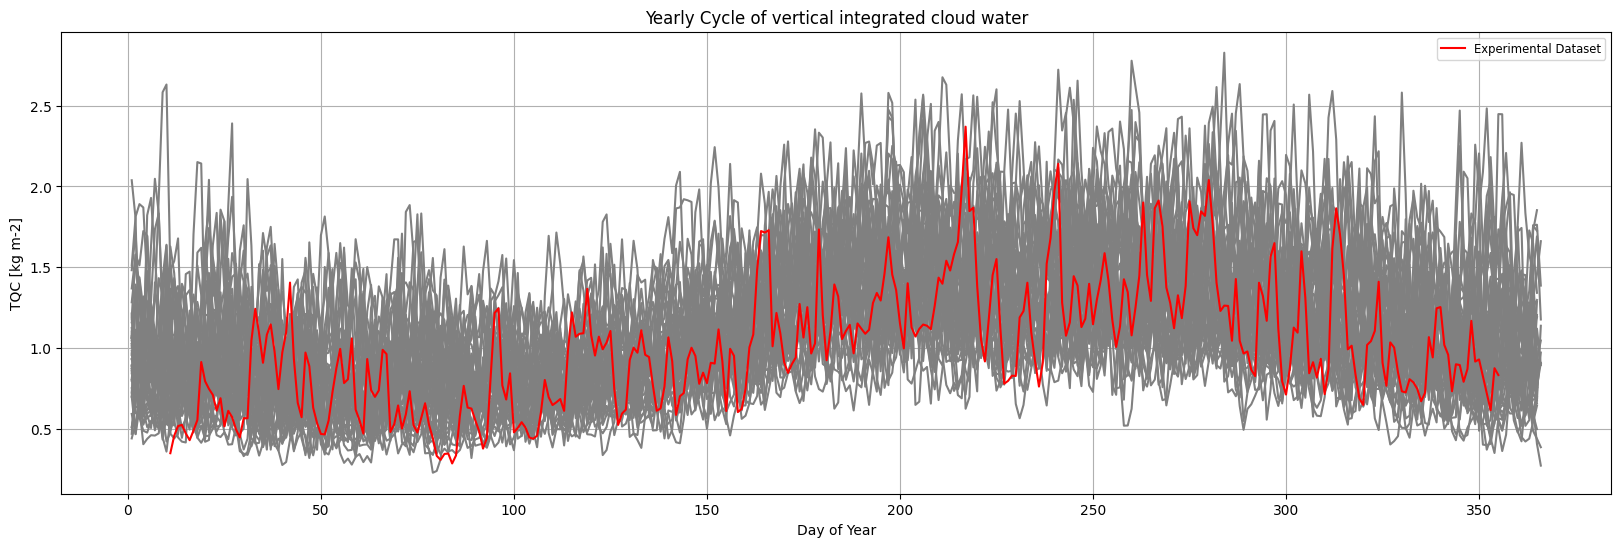

In [54]:
get_spaghetti_GLUE(da_mean_eval, da_mean_exp, variable)

In [55]:
da_eval_yearly_avg

<xarray.DataArray 'TQC' (year: 45, rlat: 414, rlon: 426)> Size: 32MB
dask.array<stack, shape=(45, 414, 426), dtype=float32, chunksize=(1, 414, 426), chunktype=numpy.ndarray>
Coordinates:
    lon      (rlat, rlon) float32 705kB dask.array<chunksize=(414, 426), meta=np.ndarray>
    lat      (rlat, rlon) float32 705kB dask.array<chunksize=(414, 426), meta=np.ndarray>
  * rlon     (rlon) float32 2kB -28.49 -28.38 -28.26 ... 18.05 18.16 18.26
  * rlat     (rlat) float32 2kB -23.49 -23.38 -23.26 ... 21.73 21.83 21.94
  * year     (year) int64 360B 1979 1980 1981 1982 1983 ... 2020 2021 2022 2023
Attributes:
    standard_name:  atmosphere_mass_content_of_cloud_liquid_water
    long_name:      vertical integrated cloud water
    units:          kg m-2
    grid_mapping:   rotated_pole
    cell_methods:   time: point

everything fine
Plotting Evaluation
Plotting Experiment
Plotting Bias


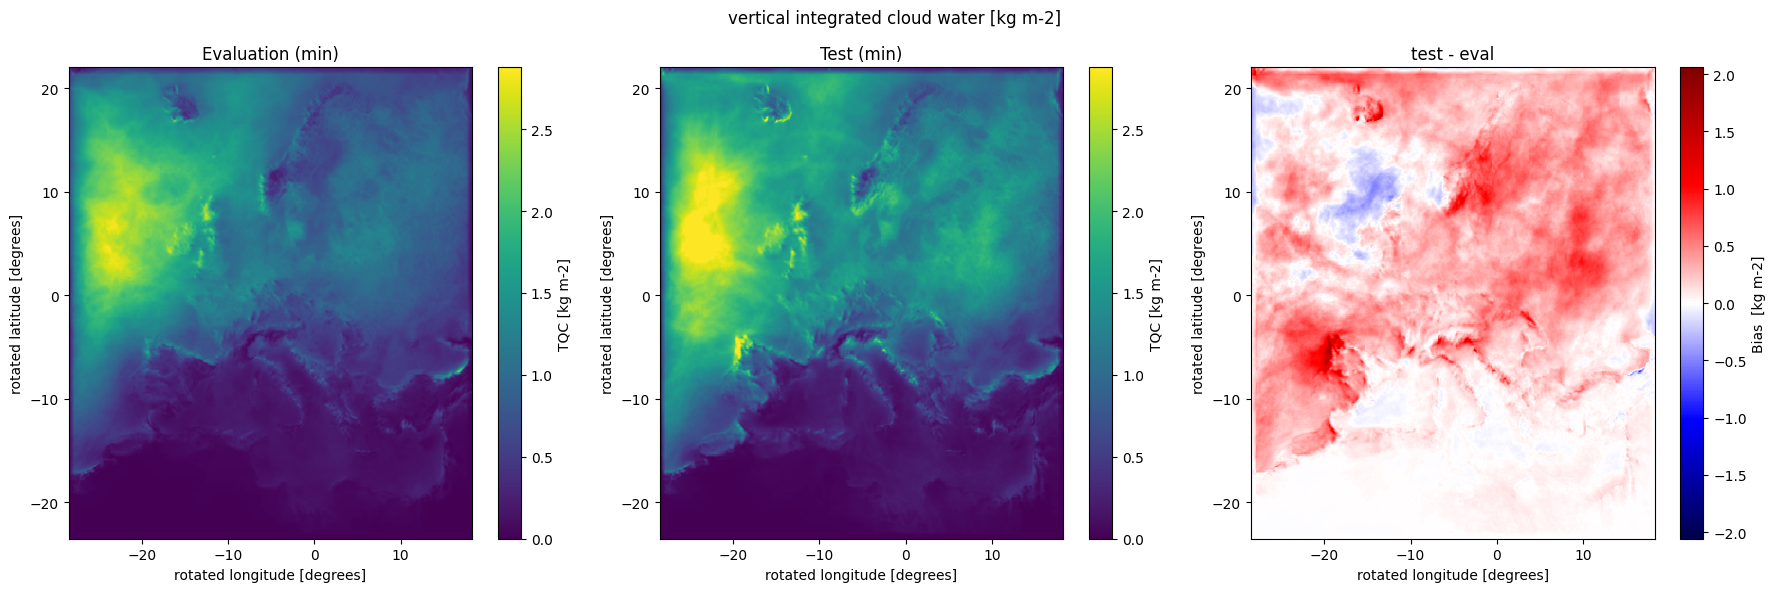

In [56]:
calc_plot_bias_map_eval(variable, da_eval_yearly_avg, da_exp_yearly_avg, months_to_analyse = [1,2,3,4,5,6,7,8,9,10,11,12], region='europe', statistic ='min')

everything fine
Plotting Evaluation
Plotting Experiment
Plotting Bias


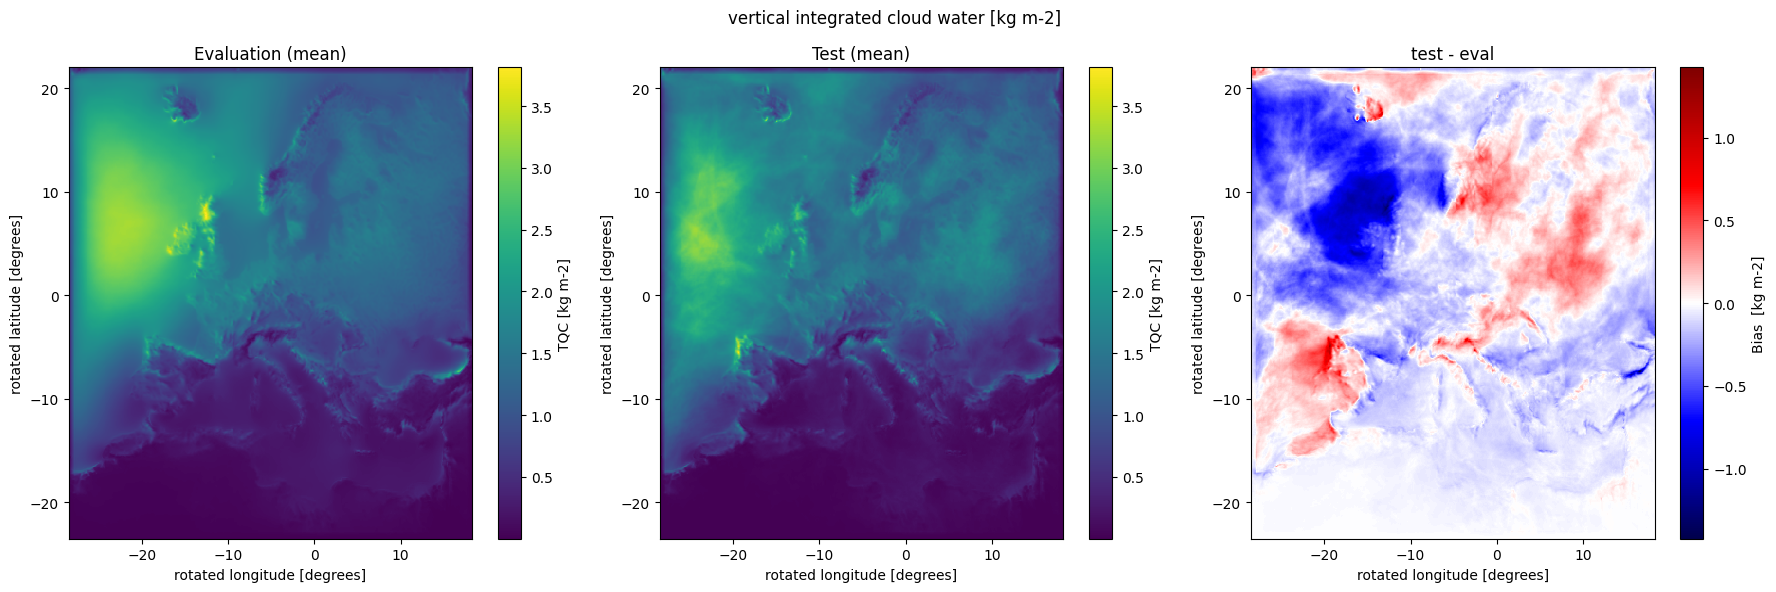

In [57]:
calc_plot_bias_map_eval(variable, da_eval_yearly_avg, da_exp_yearly_avg, months_to_analyse = [1,2,3,4,5,6,7,8,9,10,11,12], region='europe', statistic ='mean')

everything fine
Plotting Evaluation
Plotting Experiment
Plotting Bias


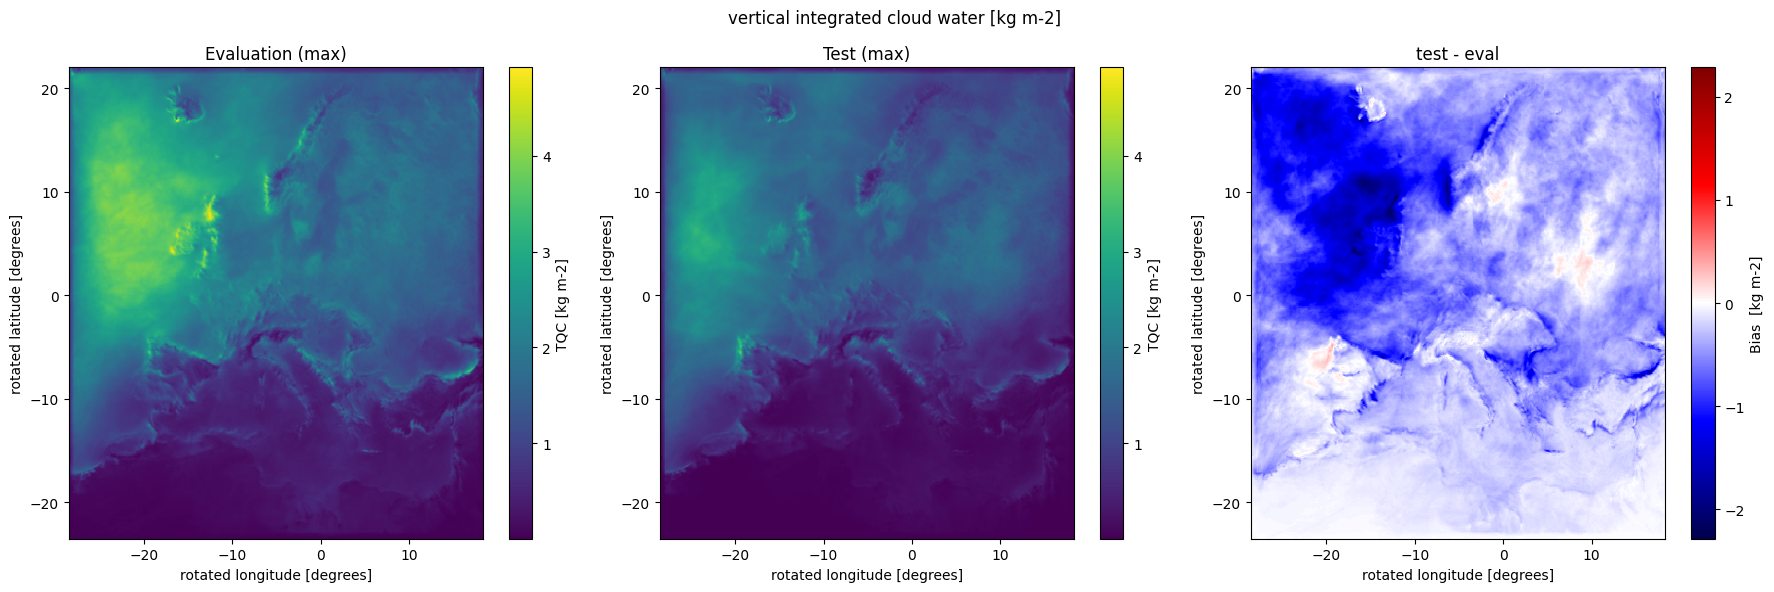

In [58]:
calc_plot_bias_map_eval(variable, da_eval_yearly_avg, da_exp_yearly_avg, months_to_analyse = [1,2,3,4,5,6,7,8,9,10,11,12], region='europe', statistic ='max')

In [59]:
# d_rankyears = rank_years(ds_mean_eval.groupby('time.year').mean()[1:-1])
# d_rankyears

In [60]:
statistics = ["mean"]
stat_eval_daily = get_temporal_stats(dataset = da_mean_eval, variable = variable, frequency="daily", statistics = statistics)
stat_exp_daily = get_temporal_stats(dataset = da_mean_exp, variable = variable, frequency="daily", statistics = statistics)
stat_eval_yearly = get_temporal_stats(dataset = da_mean_eval, variable = variable, frequency="yearly", statistics = statistics)
stat_exp_yearly = get_temporal_stats(dataset = da_mean_exp, variable = variable, frequency="yearly", statistics = statistics)

KeyboardInterrupt: 

In [ ]:
# Takes very long
statistics_to_plot = statistics  # Example list of statistics

# Plot the daily statistics
plot_temporal_stats(stat_eval_daily, da_mean_exp, statistics=statistics_to_plot, variable=variable, frequency = "daily")

: 

: 

: 

## 3. Calculation of P5, P50, P95 for each year 
In this example, the P5, P50 and P95 for each year are calculated for the reference run and the test year. 

### Calculate daily and yearly statistics
- Mean, median
- min, max
- standard deviation
- percentiles

### Visualize yearly statistics
- boxplot
- lineplots


In [36]:
#def calc_and_plot_bias_map_eval(eval_dataset, exp_dataset, variable):


IndentationError: expected an indented block (3710973333.py, line 1)

: 

: 

: 

In [39]:
da_abs_minima, da_abs_maxima, scaled_exp = min_max_scaling(da_eval_yearly_avg, da_exp_yearly_avg, variable)

Started with determining absolute minima and maxima
Started with scaling
experiment is scaled


: 

: 

: 

Plotting minima
Plotting scaled experiment data
Plotting maxima


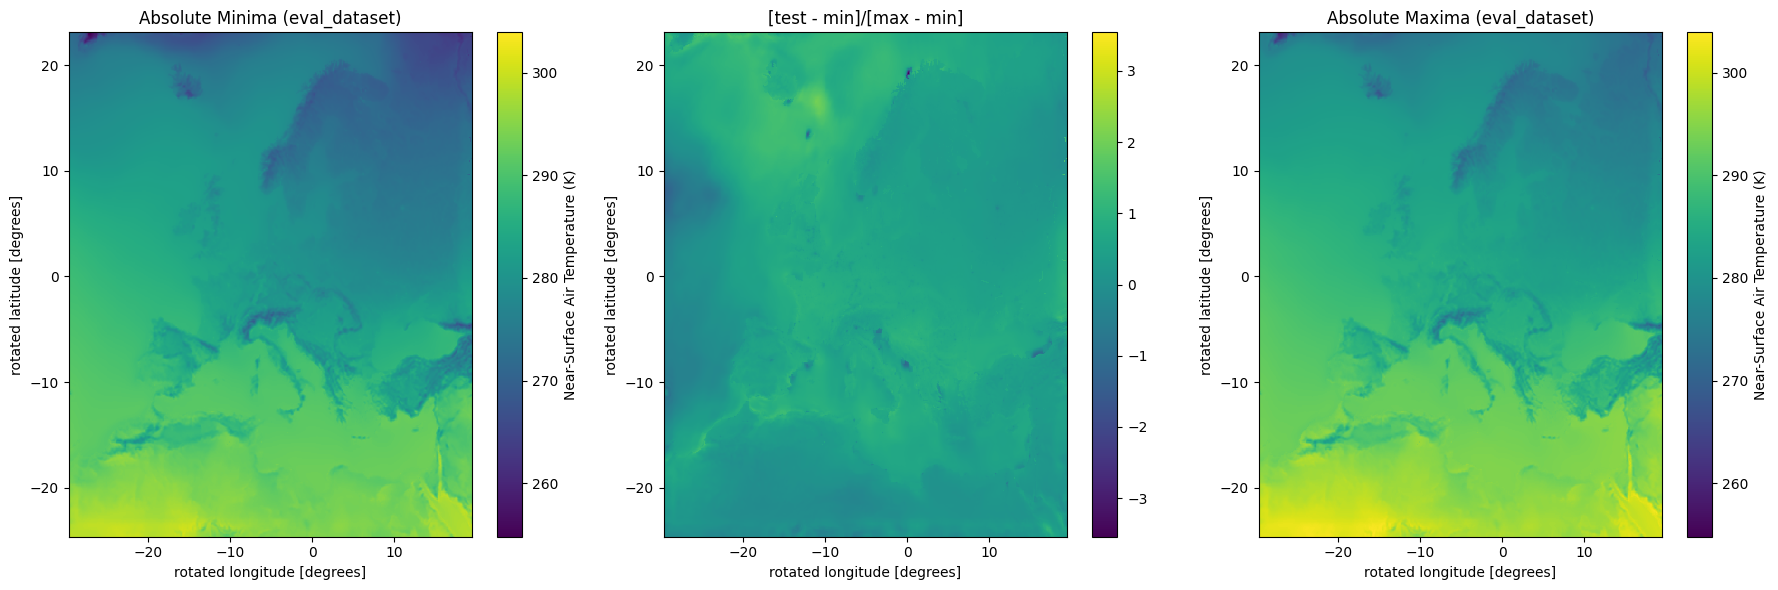

: 

: 

: 

In [82]:
visualize_min_max_scaling(da_abs_minima, da_abs_maxima, scaled_exp, variable)

In [41]:
gridfile = manager._get_file_paths("ERA5",variable, period=[1995,1995],freq="daily",region="europe")[0]
gridfile

PosixPath('/dodrio/scratch/projects/2022_200/external/era5/europe/2m_temperature/daily/2m_temperature_era5_europe_daily_max_1995.nc')

: 

: 

: 

In [146]:
stat_eval_spatial = get_spatial_stats(dataset = da_eval, variable = variable, statistics = ["mean", 'min', "max"])
stat_exp_spatial = get_spatial_stats(dataset = da_exp, variable = variable, statistics = ["mean", 'min', "max"])

: 

: 

: 

In [74]:
stat_eval_yearly["mean"].values.flatten()

array([283.9173 , 284.3387 , 284.1807 , 284.43982, 284.17407, 283.9344 ,
       284.03033, 284.07272, 284.45233, 284.81497, 284.863  , 284.4447 ,
       284.25848, 284.17603, 284.58398, 284.7344 , 284.235  , 284.42105,
       284.48956, 284.87323, 284.8167 , 284.9148 , 284.83627, 284.96814,
       284.849  , 284.888  , 284.9432 , 285.19144, 285.10577, 284.89636,
       285.00342, 284.9168 , 284.9756 , 284.9882 , 285.26974, 285.12332,
       285.3232 , 285.24982, 285.29083, 285.36844, 285.6536 , 285.3138 ],
      dtype=float32)

: 

: 

: 

1 done
2 done
ready to plot


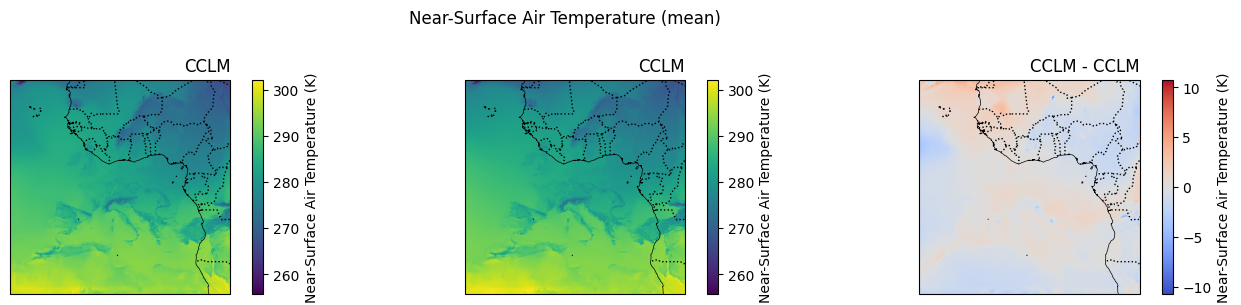

: 

: 

: 

In [ ]:
statistics_to_plot = ["mean"]
plot_spatial_stats(stat_eval_spatial, stat_exp_spatial, variable, statistics_to_plot)